In [79]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import os    # file management
import pandas as pd   # data frames
import importlib   # for reloading your own files

# my own file:
import full_bubble_model as de    # full bubble model
importlib.reload(de)   # reload changes you made

model: chemkin_AR_HE


<module 'full_bubble_model' from 'F:\\OneDrive - Budapesti Műszaki és Gazdaságtudományi Egyetem\\TDK\\Letisztázott programok\\full_bubble_model.py'>

In [80]:
"""Base settings"""

directory = 'F:\\OneDrive - Budapesti Műszaki és Gazdaságtudományi Egyetem\\TDK\\Letisztázott programok\\test 1'
file_base_name = 'output_'

In [81]:
"""Load all CSV files from directory into a dataframe (all_data)"""

# list all files in a given directory
def list_all_files(directory):
    list_of_files = os.listdir(directory)
    all_files = []
    # Iterate over all the entries
    for entry in list_of_files:
        # Create full path
        full_path = os.path.join(directory, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(full_path):
            all_files = all_files + list_all_files(full_path)
        else:
            all_files.append(full_path)
                
    return all_files

# create a dataframe
all_data = pd.DataFrame()

# Load all files
parent_dir = os.getcwd()
save_dir = os.path.join(parent_dir, directory)
all_files = list_all_files(save_dir)
num = 0
print(f'Found files:')
for file in all_files:
    # check if it's a CSV starting with file_base_name
    file_name = os.path.basename(file)
    if file_name[-4:] != '.csv':
        continue
    if file_name[:len(file_base_name)] != file_base_name:
        continue
    
    # Load csv into all_data
    current_data = pd.read_csv(file)
    print(f'\t{file_name}\t({current_data.shape[0]} rows)')
    all_data = pd.concat([all_data, current_data])
    num += 1
    
# Print some stats:
print(f'_______________________________________')
print(f'total number of files: {num}')
total = all_data.shape[0]
print(f'total:  {total} rows   (100 %)')
for error_code in range(7):
    num = all_data.loc[(all_data['error_code'] == error_code)].shape[0]
    print(f'error code {error_code}: {num} rows   ({(100*num/total):.2f} %)')
num = all_data.loc[(all_data['T_max'] > 6000.0)].shape[0]
print(f'too hot: {num} rows    ({100*num/total:.2f} %)')
print(f'_______________________________________')

Found files:
	output_1.csv	(101 rows)
	output_2.csv	(101 rows)
	output_3.csv	(101 rows)
	output_4.csv	(97 rows)
_______________________________________
total number of files: 4
total:  400 rows   (100 %)
error code 0: 388 rows   (97.00 %)
error code 1: 11 rows   (2.75 %)
error code 2: 1 rows   (0.25 %)
error code 3: 0 rows   (0.00 %)
error code 4: 0 rows   (0.00 %)
error code 5: 0 rows   (0.00 %)
error code 6: 0 rows   (0.00 %)
too hot: 0 rows    (0.00 %)
_______________________________________


In [82]:
"""Locate valid (good_data) and wrong (wrong_data) simulations"""

# Get valid datas
good_data = all_data.loc[
    (all_data['error_code'] < 4) &
    (all_data['energy'] > 0.0) & (all_data['energy'] == all_data['energy']) # positive not NaN
    # or set negative energy to inf: good_data.loc[good_data['energy'] < 0.0, 'energy'] = 1e10
]

# Everything that's not in good_data
wrong_data = pd.concat([good_data, all_data]).drop_duplicates(keep=False)

# Sort by energy
good_data = good_data.sort_values(['energy'], ascending=True)

# New column
good_data['logE'] = np.log10(good_data['energy'])
print(f'Good data: {good_data.shape[0]} rows ({100*good_data.shape[0]/all_data.shape[0]: .2f} %)')

Good data: 392 rows ( 98.00 %)


In [83]:
"""Let's see the dataframe"""

good_data[['ID', 'error_code', 'steps', 'elapsed_time', 'T_max', 'collapse_time', 'n_H2', 'n_O2',
           'work', 'energy', 'R_E', 'ratio', 'P_inf', 'alfa_M', 'T_inf', 'surfactant']]

,ID,error_code,steps,elapsed_time,T_max,collapse_time,n_H2,n_O2,work,energy,R_E,ratio,P_inf,alfa_M,T_inf,surfactant
83,287,0,21184,3.007986,3348.806669,8.871324e-07,3.853371e-14,1.921590e-14,8.022496e-07,1.032740e+04,0.000015,3.0,2500000.0,0.05,303.15,1.0
11,11,0,9539,1.203793,4048.145176,9.422506e-08,5.826819e-17,2.864245e-17,1.264638e-09,1.076607e+04,0.000001,5.0,2500000.0,0.05,303.15,1.0
44,247,0,19640,2.766630,3347.578930,5.910587e-07,1.092479e-14,5.444652e-15,2.378785e-07,1.080102e+04,0.000010,3.0,2500000.0,0.05,303.15,1.0
23,327,0,19095,3.109716,3341.777856,1.183309e-06,8.523446e-14,4.250282e-14,1.900929e-06,1.106300e+04,0.000020,3.0,2500000.0,0.05,303.15,1.0
51,51,0,12898,1.686507,4297.195383,1.887870e-07,4.501812e-16,2.242291e-16,1.004193e-08,1.106502e+04,0.000002,5.0,2500000.0,0.05,303.15,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,5,0,4928,0.556518,1018.437053,2.454557e-07,2.305633e-39,2.174785e-51,1.435461e-11,3.088330e+24,0.000001,3.0,100000.0,0.05,303.15,1.0
1,2,0,4168,0.492687,1023.043612,6.602701e-08,1.177092e-39,4.361522e-47,2.198313e-11,9.264063e+24,0.000001,2.0,1000000.0,0.05,303.15,1.0
54,361,0,3921,0.433844,840.983045,5.278138e-06,1.746925e-40,-2.638051e-49,3.174999e-08,9.015537e+28,0.000025,2.0,100000.0,0.05,303.15,1.0
97,201,0,5069,0.574470,719.403808,1.539207e-06,6.107976e-44,6.039862e-40,9.147150e-10,7.428667e+30,0.000007,2.0,100000.0,0.05,303.15,1.0


In [84]:
"""Print some statistics"""

good_data[['ID', 'error_code', 'steps', 'elapsed_time', 'T_max', 'collapse_time', 'n_H2', 'n_O2',
           'work', 'energy', 'R_E', 'ratio', 'P_inf', 'alfa_M', 'T_inf', 'surfactant']].describe()

,ID,error_code,steps,elapsed_time,T_max,collapse_time,n_H2,n_O2,work,energy,R_E,ratio,P_inf,alfa_M,T_inf,surfactant
count,392.000000,392.000000,392.000000,392.000000,392.000000,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,392.000000,392.000000,3.920000e+02,3.920000e+02,3.920000e+02,392.0
mean,200.890306,0.030612,16389.237245,3.209362,2848.487572,7.328039e-06,9.417885e-13,4.699527e-13,6.413495e-04,2.039527e+29,0.000009,20.367347,2.179337e+06,5.000000e-02,3.031500e+02,1.0
std,115.300411,0.186725,8417.767007,15.647942,977.351858,1.385265e-05,3.704524e-12,1.849220e-12,3.034469e-03,3.676525e+30,0.000008,15.412081,1.850639e+06,3.612836e-16,1.992062e-12,0.0
min,2.000000,0.000000,3921.000000,0.433844,672.272326,3.044675e-08,1.939439e-45,-5.123544e-21,1.435461e-11,1.032740e+04,0.000001,2.000000,1.000000e+05,5.000000e-02,3.031500e+02,1.0
25%,101.750000,0.000000,11558.000000,1.429193,1958.563737,8.004420e-07,1.160631e-17,2.503669e-18,9.912761e-08,1.757408e+05,0.000003,5.000000,1.000000e+06,5.000000e-02,3.031500e+02,1.0
50%,200.500000,0.000000,14530.000000,1.981720,2970.616210,2.351930e-06,4.409800e-15,2.190558e-15,2.860115e-06,3.304906e+05,0.000006,20.000000,2.500000e+06,5.000000e-02,3.031500e+02,1.0
75%,300.250000,0.000000,19057.000000,2.815749,3422.786923,7.355261e-06,1.488296e-13,7.419877e-14,7.048040e-05,2.910602e+07,0.000015,30.000000,5.000000e+06,5.000000e-02,3.031500e+02,1.0
max,400.000000,2.000000,80541.000000,310.114941,5427.979490,1.180227e-04,4.224774e-11,2.109612e-11,4.086867e-02,7.243062e+31,0.000025,50.000000,5.000000e+06,5.000000e-02,3.031500e+02,1.0


succecfully solved with LSODA solver


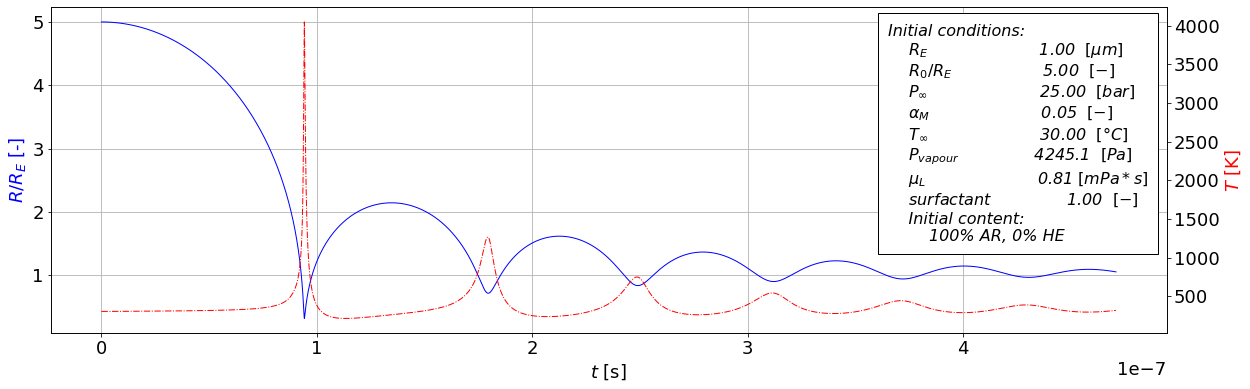

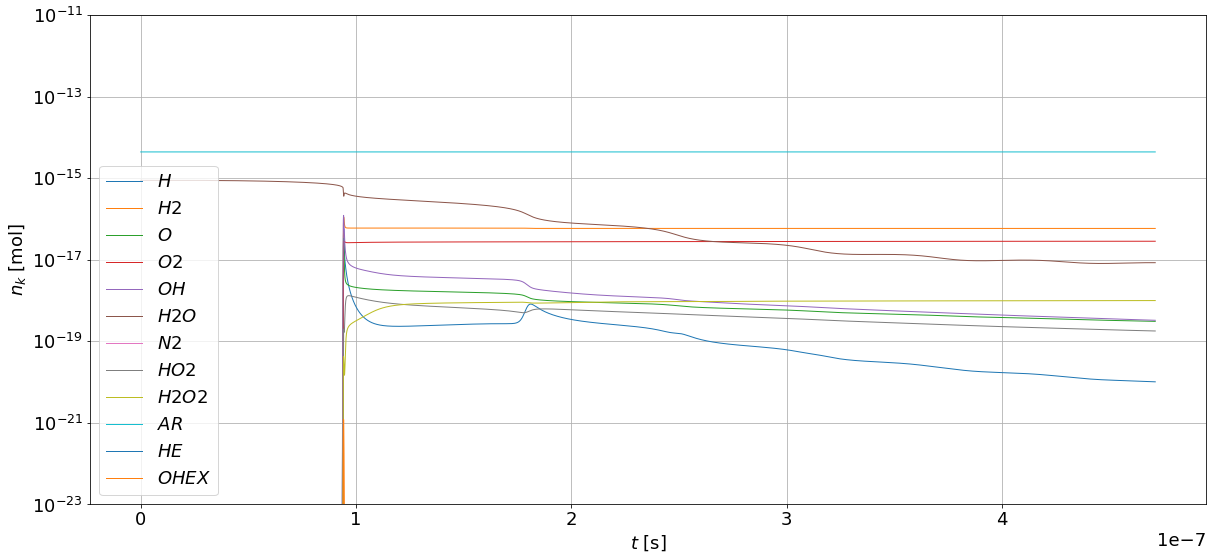

Control parameters:
    ID = 11
    R_E = 1.00 [um]
    ratio = 5.00 [-]
    P_inf = 25.00 [bar]
    alfa_M = 0.05 [-]
    T_inf = 30.00 [°C]
    P_v = 4245.13 [Pa]
    mu_L = 0.81 [mPa*s]
    surfactant = 1.00 [-]
    100% AR, 0% HE
Simulation info:
    error_code = 0
    elapsed_time = 1.10 [s]
    steps = 9539 [-]
Final state:
    R_final = 1.01 [um];   R_dot_final =1.129169540508806e-17 [m/s];   T_final = 303.15 [K]
    n_H2 =5.826818607281378e-17 [mol]; n_O2 =2.864245341970364e-17 [mol]
    Final molar concentrations: [mol/cm^3]
        H: -4.994195859260988e-21;  H2: 1.3632275940074182e-05;  O: -3.4107975464517105e-15;  O2: 6.701115221438125e-06;  
        OH: -1.0036204724547934e-19;  H2O: 1.6842204457612123e-06;  N2: 0.0;  HO2: -2.4113237248546457e-11;  
        H2O2: 2.300816704644442e-07;  AR: 0.0010263315529529951;  HE: 0.0;  OHEX: 8.056090647320269e-45;  
        
Results:
    collapse_time = 9.422505710336362e-08 [s]
    T_max = 4048.15 [K]
    expansion work = 1.264638360

In [85]:
"""Plot a certain simulation"""

# converts a line of all_data to a dictionary containing the control parameters (cpar)
def line_to_dict(line):
    gases = str(line['gases'])
    fractions = str(line['fractions'])
    return de.dotdict(dict(
        ID=line['ID'],
        R_E=line['R_E'], # [m]
        ratio=line['ratio'], # [-]
        P_inf=line['P_inf'], # [Pa]
        alfa_M=line['alfa_M'], # [-]
        T_inf=line['T_inf'], # [K]
        surfactant=line['surfactant'], # [-]
        P_v=line['P_v'], # [Pa]
        mu_L=line['mu_L'], # [Pa*s]
        gases=[int(index) for index in gases.split(' ') if index!=''],  # indexes of species in initial bubble
        fractions=[float(frac) for frac in fractions.split(' ') if frac!=''], # molar fractions of species in initial bubble
    ))
    
cpar = line_to_dict(good_data.iloc[1])   # choose the most energy efficient one
de.plot(cpar)